In [3]:
import numpy as np
import matplotlib.pyplot as plt
import simim.siminterface as sim

tng100 = sim.SimHandler('TNG100-1')
rng = np.random.default_rng(1511)
pixel_size = tng100.box_edge_no_h / 450

In [32]:
from simim.galprops import prop_behroozi_sfr, prop_delooze_cii, prop_padmanabhan_cii, prop_yang_cii

tng100.make_property(prop_behroozi_sfr, other_kws={'scatter': False}, overwrite=True, rename='sfr_behroozi', write=True)
tng100.make_property(prop_delooze_cii, other_kws={'scatter': False}, overwrite=True, rename='LCII', kw_remap={'sfr': 'sfr_behroozi'}, write=True)

/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:312: UserWarning: Property sfr_behroozi already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/siminterface/simhandler.py:582: UserWarning: Property sfr_behroozi already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:371: UserWarning: Property sfr_behroozi already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(property_name))


Assigning props for Snapshot 99.  


/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:312: UserWarning: Property LCII already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/siminterface/simhandler.py:582: UserWarning: Property LCII already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:371: UserWarning: Property LCII already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(property_name))


Assigning props for Snapshot 99.  


In [34]:
from astropy import constants as con
from astropy import units as u
from simim import constants as sc
MPC_TO_M = u.Mpc.to(u.m)
JY_CONVERSION = 1/u.Jy.to(u.W / u.m**2 / u.Hz)

def _calculate_Ldensity_to_Jy_conversion(nu_rest, snap, z):
    """Conversion factor from Lsun/Mpc^3 to Jy/sr at redshift self.z."""
    # conversion factor
    conversion = (con.c.to(u.m/u.s).value / (4.0 * np.pi)) * \
        (sc.Lsun_to_W / MPC_TO_M**3) / (snap.cosmo.H(z).to(1/u.s).value * nu_rest) * JY_CONVERSION
    return conversion

In [35]:
from tqdm import tqdm
Inus, zs = [], []
NSNAPS = 100

for i in tqdm(range(NSNAPS)):
    snap = tng100.get_snap(i)
    z = snap.redshift
    volume = snap.box_edge ** 3
    linevals = snap.return_property("LCII")
    Inu = _calculate_Ldensity_to_Jy_conversion(sc.nu_cii, snap, z) * np.nansum(linevals) / volume
    Inus.append(Inu)
    zs.append(z)

100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


In [50]:
# fit a polynomial to log-log, with scipy to get error bars
zs = np.array(zs)
Inus = np.array(Inus)
logz = np.log10(1 + zs)
logInu = np.log10(Inus)
coeffs = np.polyfit(logz, logInu, 3)
poly = np.poly1d(coeffs)
fitInu = 10**poly(logz)

In [53]:
np.savez('../../../../LIM_archival/figs/review/newdata/Inu_vs_z_behroozi_delooze.npz', zs=zs, Inus=Inus, fitInu=fitInu)

In [ ]:
np.load('../../../../LIM_archival/figs/review/newdata/Inu_vs_z_behroozi_delooze.npz')

['zs', 'Inus', 'fitInu']

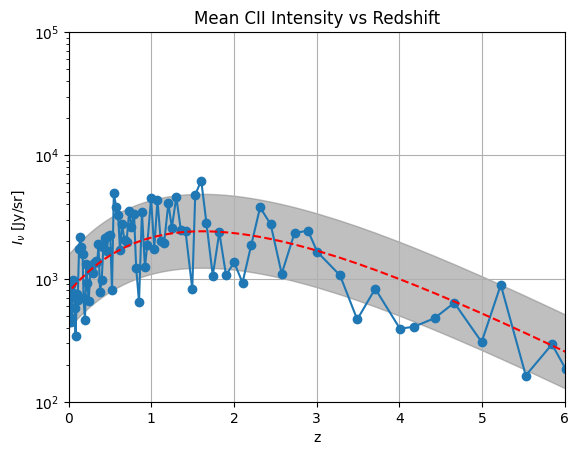

In [52]:
scatter = .3

plt.figure()
plt.plot(zs, Inus, 'o-')
plt.plot(zs, fitInu, 'r--')
plt.fill_between(zs, fitInu*10**(-scatter), fitInu*10**(scatter), color='gray', alpha=0.5, label=r'$\pm$0.1 dex scatter')
plt.xlabel('z')
plt.ylabel(r'$I_{\nu}$ [Jy/sr]')
plt.yscale('log')
plt.title('Mean CII Intensity vs Redshift')
plt.ylim(1e2, 1e5)
plt.xlim(0, 6)
plt.grid()
plt.show()
plt.close()